# Modeling

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

np.random.seed(95)
import math
import itertools

In [2]:
# load data from existing csv
train = pd.read_csv("./00_project_data/1-1_training_data.csv", index_col=0)
validate = pd.read_csv("./00_project_data/1-2_validation_data.csv", index_col=0)
test = pd.read_csv("./00_project_data/1-3_testing_data.csv", index_col=0)
train.head()

,borough,bite
dateofbite,,
2015-01-01,Other,1
2015-01-01,Brooklyn,1
2015-01-01,Manhattan,1
2015-01-01,Brooklyn,1
2015-01-01,Queens,1


**Final cleaning**

In [3]:
# covert the index to datetime
train.index = train.index.astype("datetime64")
validate.index = validate.index.astype("datetime64")
test.index = test.index.astype("datetime64")

In [4]:
# train = train.resample('D').bite.sum()
# validate = validate.resample('D').bite.sum()
# test = test.resample('D').bite.sum()
# train = pd.DataFrame(train)
# validate = pd.DataFrame(validate)
# test = pd.DataFrame(test)

# train.head()

In [5]:
# resample to only weekly data
train = train.resample('w').bite.sum()
validate = validate.resample('w').bite.sum()
test = test.resample('w').bite.sum()
train = pd.DataFrame(train)
validate = pd.DataFrame(validate)
test = pd.DataFrame(test)

train.head()

,bite
dateofbite,
2015-01-04,34
2015-01-11,38
2015-01-18,40
2015-01-25,55
2015-02-01,39


**Visulize train and validate**

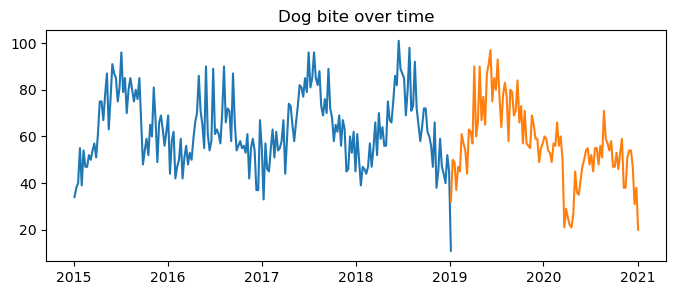

In [6]:
# plt the value value fof bite over time
plt.figure(figsize=(8,3))
plt.plot(train.bite)
plt.plot(validate.bite)
plt.title("Dog bite over time")
plt.show()

**Create an evaluation function**

evaluate() will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.

In [7]:
# evaluation funtion
def evaluate(target, model_type= 0, model_df= None):
    """
    Takes in the target col name and return the root mean square error for
    the validate/test against the predicted values.
    """
    if model_type == 1:
        rmse = round(sqrt( # get root mean square error
        mean_squared_error(validate[target], model_df[target])),3) # get mean squared error
        return rmse
    else:
        rmse = round(sqrt( # get root mean square error
            mean_squared_error(validate[target], y_pred_df[target])),3) # get mean squared error
        return rmse


**Plot evaluation funtion**

In [8]:
# plot predictions vs actual values
def plot_evaluate(target, model_type= 0, model_df=None ):
    """
    Function will return a plot of the predicted values against the actual values in the data.
    """
    if model_type == 1:
        # plt.ioff()
        # plt the value value fof bite over time and the predicted
        plt.figure(figsize=(8,3))
        plt.plot(train.bite, label="Train", linewidth=1)
        plt.plot(validate.bite,label="Validate", linewidth=1)
        plt.plot(model_df[target],label="Prediction", linewidth=1 )
        plt.title("Dog bite over time prediction")
        plt.legend()

        rmse = evaluate(target, model_type= 1, model_df= model_df)
        print(target, f'-- rmse: {round(rmse,2)}')
        return rmse
    else:
        # plt.ioff()
        # plt the value value fof bite over time and the predicted
        plt.figure(figsize=(8,3))
        plt.plot(train.bite, label="Train", linewidth=1)
        plt.plot(validate.bite,label="Validate", linewidth=1)
        plt.plot(y_pred_df[target],label="Prediction", linewidth=1 )
        plt.title("Dog bite over time prediction")
        plt.legend()

        rmse = evaluate(target)
        print(target, f'-- rmse: {round(rmse,2)}')
        return rmse

**Evaluation data frame**

In [9]:
# create evaluation dataframe
eval_df = pd.DataFrame(columns=["model", "rmse"])
eval_df

,model,rmse


In [10]:
# function to append to the evaluation dataframe
def append_to_eval(model, target):
    """
    Function append the current running model results the historical models.
    """
    rmse = evaluate(target)
    res_dict = pd.DataFrame({"model":[model],
               "rmse":[rmse]})
    return pd.concat([eval_df, res_dict])

In [11]:
# rmse = evaluate(target)
#     print(target, f'-- rmse: {round(rmse,2)}')

## Moving Average

I will use a iterating day lag moving average to forecast.

In [12]:
# looking at 2% of the validation data
lags = math.ceil(validate.shape[0] * .3)

predictions_dfs = []
for i in range(1, lags + 1):
    # get the average over a lot of different weeks
    rolling_avg = round(train.bite.rolling(i).mean()[-1],2)
    
    # predict baseline over time
    y_pred_df = pd.DataFrame({"bite": rolling_avg}, index=validate.index)
    
    # add to moving average predictions dataframes
    predictions_dfs.append(y_pred_df)
    
    # update the evaluate dataframe
    model_type = str(i) + '-wk moving avg'
    eval_df= append_to_eval(model=model_type, target="bite")
    

In [13]:
# base model rmse
mv_avg_rmse_df = eval_df.reset_index(drop=True)
mv_avg_rmse_df[mv_avg_rmse_df.rmse == mv_avg_rmse_df.rmse.min()]

,model,rmse
22,23-wk moving avg,16.449


**Plot best moving average**

In [14]:
# find best baseline model
mov_avg_pred = pd.DataFrame(predictions_dfs[22],
                             index=validate.index)
mov_avg_pred.head()

,bite
dateofbite,
2019-01-06,57.0
2019-01-13,57.0
2019-01-20,57.0
2019-01-27,57.0
2019-02-03,57.0


bite -- rmse: 16.45


16.449

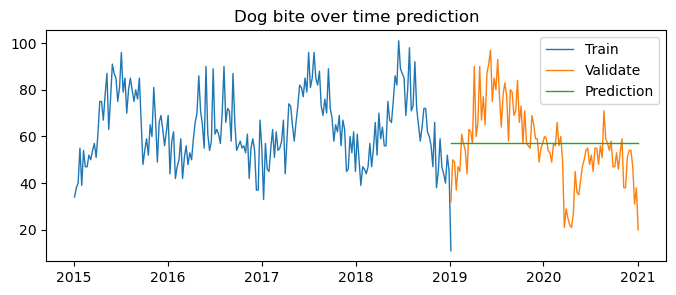

In [15]:
# Plot prediction
plot_evaluate(target= "bite", model_type= 1, model_df= predictions_dfs[22])

## Holt linear trend

In [16]:
# create object fit and predict
model = Holt(train["bite"], exponential=False, damped=True)
model = model.fit(optimized=True)

y_pred_values = model.predict(start=validate.index[0],
                            end= validate.index[-1])
y_pred_df["bite"] = round(y_pred_values, 3)

In [17]:
# no frequncy infomation provided so D is used
y_pred_df.head(3)

,bite
dateofbite,
2019-01-06,44.610
2019-01-13,33.838
2019-01-20,31.952


**Add to evaluation dataframe**

In [18]:
eval_df = append_to_eval(model = 'holts_optimized', 
                            target= "bite")

In [19]:
eval_df.tail(1)

,model,rmse
0,holts_optimized,38.744


bite -- rmse: 38.74


38.744

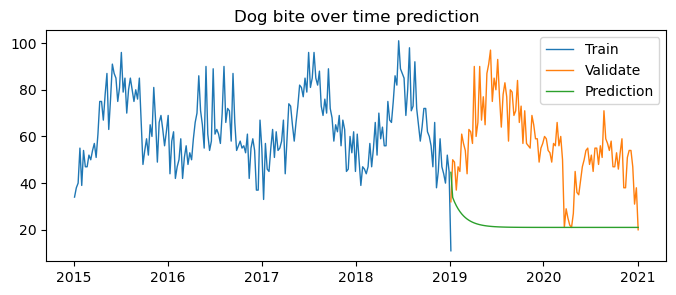

In [20]:
# Plot prediction
plot_evaluate(target= "bite") # this returns the rsme for the plot for evaluation

## Holts seasonal trend

In [21]:
# get combinations to pass to model object
combos = list(itertools.product(['add','mul'],[True, False]))
combos

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [22]:
# # Models for quantity
# # 52 because there is 52 weeks in a year and our data has been sampled by week
hsts = {}

for i, combo in enumerate(combos):
    hsts['hst_fit_' + str(i)] = ExponentialSmoothing(train.bite, seasonal_periods=52, trend='add', seasonal=combo[0], damped=combo[1]).fit()
hsts

{'hst_fit_0': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x104d46590>,
 'hst_fit_1': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x16933e0b0>,
 'hst_fit_2': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x16933dc00>,
 'hst_fit_3': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x16933d150>}

The model contains a SSE attribute that we can use to compare performance. We can derive RMSE from SSE, but for now, we can just use SSE to look at the relative performance of our Holt's Seasonal Trend models.

In [23]:
hsts_score_eval_df = {}
# compare our rmse
for model, obj in hsts.items():
    score = sqrt(hsts[model].sse / len(train)) # compute the evaluation score (chose the smallest as best to run predictions)
    hsts_score_eval_df[model] = [round(score, 3)]
hsts_score_eval_df

{'hst_fit_0': [8.374],
 'hst_fit_1': [8.456],
 'hst_fit_2': [8.416],
 'hst_fit_3': [8.522]}

**Mke predictions and plot**

Make predictions best on best score

In [24]:
# assign the prediction results to a dataframe
y_pred_df = pd.DataFrame(hsts['hst_fit_0'].forecast(validate.shape[0]), columns=["bite"])
y_pred_df.head()

,bite
2019-01-13,42.034428
2019-01-20,40.753992
2019-01-27,33.095373
2019-02-03,40.024574
2019-02-10,40.288643


bite -- rmse: 17.25


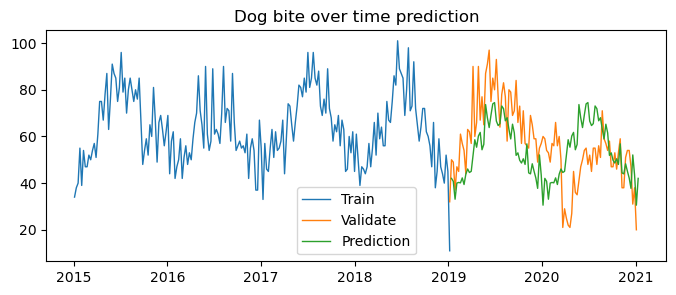

In [25]:
# Plot prediction
best_hsts_rmse = plot_evaluate(target= "bite") # this returns the rsme for the plot for evaluation

**Add rmse to evaluation dataframe**

In [26]:
# # add current model rmse to evaluation dataframe
# eval_df= pd.concat([eval_df.reset_index(drop=True), current_model], axis=0)    


# Create a new row as a dictionary
hsts_rmse = {'model':'hst_fit_0',
             'rmse':best_hsts_rmse}

# Append the new row to the existing data frame
eval_df = eval_df.append(hsts_rmse, ignore_index=True)

# Predict base on previous cycle

In [27]:
# Calculates the difference of a DataFrame element compared with another element
# period (lag) (must be th lenght of the validation season)
mean_diff = train.diff(periods=52 * 2).mean()
mean_diff

bite    1.40566
dtype: float64

In [28]:
# find the diff. add to each value in 2015.
y_pred_df = train['2016':'2017'] + mean_diff

# set yhat_df to index of validate
y_pred_df.index = validate.index

In [29]:
validate.tail()

,bite
dateofbite,
2020-12-06,54
2020-12-13,47
2020-12-20,31
2020-12-27,38
2021-01-03,20


**Add to evaluation dataframe**

bite -- rmse: 21.76


,model,rmse
32,holts_optimized,38.744
33,hst_fit_0,17.248
0,previous year,21.760


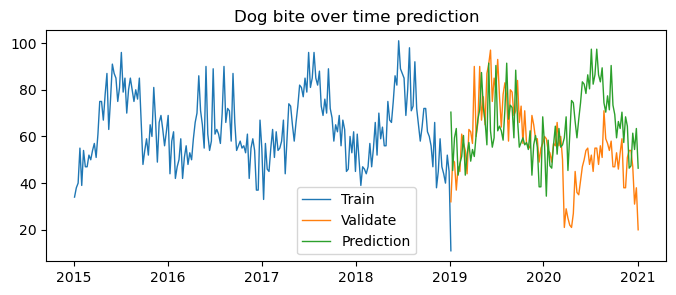

In [30]:
# add results to the evaluation dataframe
plot_evaluate(target= "bite")
eval_df = append_to_eval(model = 'previous year', target = "bite")
eval_df.tail(3)

## Best model

In [31]:
# reset the index
eval_df = eval_df.reset_index(drop=True)

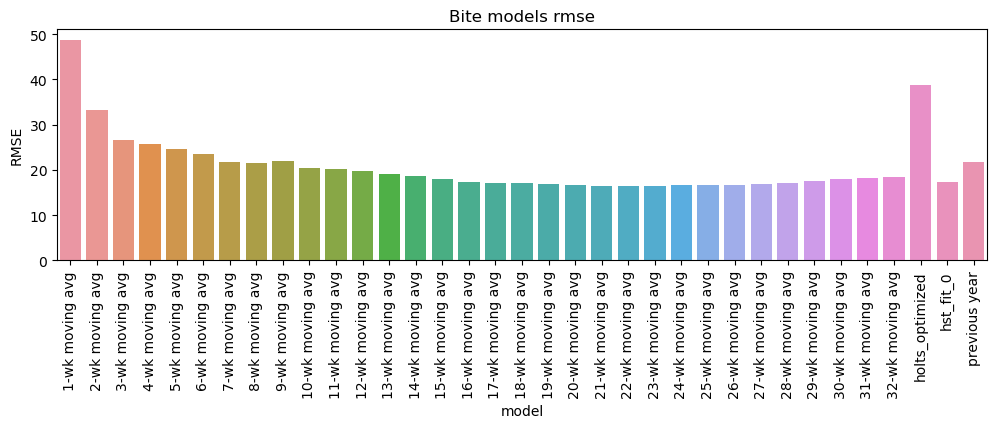

In [32]:
plt.figure(figsize=(12, 3))
sns.barplot(data= eval_df, x="model", y="rmse")
plt.title("Bite models rmse")
plt.ylabel('RMSE')
plt.xticks(rotation=90)
plt.show()

## Test

- Testing on the base model (Moving average) because I failed to bredict better than the baseline.

In [36]:
# Final Test
# get best model average
rolling_avg = round(validate.bite.rolling(23).mean()[-1],3)

# make predictions
y_final_pred_df = pd.DataFrame({"bite": rolling_avg}, index=test.index)

# update the evaluate dataframe
model_type = '23-wk moving avg'
rmse = round(sqrt(mean_squared_error(test["bite"], y_final_pred_df["bite"])),3) # root get mean squared error
model_type, rmse

('23-wk moving avg', 15.762)

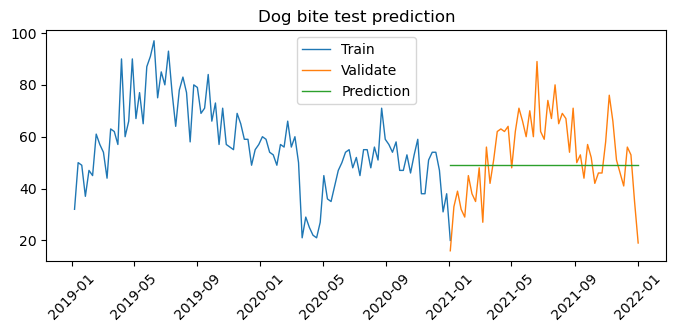

In [45]:
# Plot test results
plt.figure(figsize=(8,3))
# plt.plot(train.bite, label="Train", linewidth=1)
plt.plot(validate.bite, label="Train", linewidth=1)
plt.plot(test.bite,label="Validate", linewidth=1)
plt.plot(y_final_pred_df['bite'],label="Prediction", linewidth=1 )
plt.title("Dog bite test prediction")
plt.xticks(rotation=45)
plt.legend()